In [1]:
import tensorflow as tf
import math, re, os
from RPCC_metric_utils_for_participants import contest_metric,sive_diam_pan
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


In [2]:
def get_submit(cnt_preds, dist_preds, indices):
    submit = []
    for idx, cnt, dist in zip(indices, cnt_preds, dist_preds):
        cnt = int(cnt)
        sizes = np.random.choice(sive_diam_pan, size=cnt, p=dist / np.sum(dist))
        submit.extend([{
            "ImageId": idx,
            "prop_size": sizes[i]
        } for i in range(cnt)])
    return pd.DataFrame.from_records(submit)

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment 
    # variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
TARGET_SIZE= [384,384]
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 30
NUM_FOLDS = 5
RANDOM_STATE = 800
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0002
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [6]:
def decode_image(filename, label=None, image_size=TARGET_SIZE):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.
#     try:
#         if image.shape[0]>image.shape[1]:
#             image = tf.image.transpose(image)
#         image = tf.image.crop_to_bounding_box(image, 0, int((image.shape[1] - image.shape[0])*.75) , int(image.shape[0]), int(image.shape[0]))
#     except TypeError:
#         pass
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = transform(image)
    
    if label is None:
        return image
    else:
        return image, label

In [7]:
def get_model():
#     with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (*TARGET_SIZE, 3), name = 'inp1')
        pretrained_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False)

        pretrained_model.trainable = False

        x = pretrained_model(inp1)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(20, activation = 'relu')(x)
        x= tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(20, activation = 'relu')(x)
        x= tf.keras.layers.Dropout(0.2)(x)
        output = tf.keras.layers.Dense(1, activation = 'linear')(x)

        model = tf.keras.models.Model(inputs = [inp1], outputs = [output])

        # opt = tfa.optimizers.SWA(opt)

        model.compile(
            optimizer = 'adam',
            loss = 'mape',
            metrics = ['mape']
        )

        return model

In [8]:
TARGET_SIZE = [384,384]
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 4
EPOCHS = 500
NUM_FOLDS = 5
RANDOM_STATE = 800

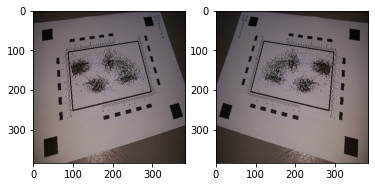

In [9]:
img = decode_image('./data/RPCC_train/train/1.jpg')

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(data_augment(img))
fig.add_subplot(1,2,2)
plt.imshow(data_augment(img))
plt.show()


In [10]:
TRAIN_FOLDER = './data/RPCC_train/train/'
train = pd.read_csv('./data/RPCC_labels.csv')
pseudotrain = train[train.fillna(-1).prop_count<0].copy()
train_count = train[train.prop_count>0]
uniques = train_count[-train_count.prop_count.duplicated()].reset_index(drop=True)

In [11]:
pseudotrain_paths = pseudotrain.ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')


pseudotrain_dataset = (
    tf.data.Dataset
    .from_tensor_slices((pseudotrain_paths))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [12]:
folds = KFold(n_splits=NUM_FOLDS,shuffle=True,random_state=RANDOM_STATE)
scores = []
for i, (train_idx,val_idx) in enumerate(folds.split(uniques)):
    pseudotrain_c = pseudotrain.copy()
    train_part, val_part =  uniques.loc[train_idx] , uniques.loc[val_idx] 
    train_part = pd.merge(train_count, train_part[['prop_count']],on=['prop_count'] ,how='inner')
    val_part = pd.merge(train_count, val_part[['prop_count']],on=['prop_count'] ,how='inner')
    
    
                                        
    train_paths = train_part[train_part.prop_count>0].ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')
    train_labels = train_part[train_part.prop_count>0].prop_count

    valid_paths = val_part[val_part.prop_count>0].ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')
    valid_labels = val_part[val_part.prop_count>0].prop_count
    
    model = get_model()

    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train_paths, train_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .cache()
        .repeat()
        .shuffle(1024)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((valid_paths, valid_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

    history = model.fit(train_dataset,  epochs=EPOCHS  ,  steps_per_epoch=STEPS_PER_EPOCH,verbose = 1,
                validation_data= valid_dataset
    )
    
    
    validation_shit = val_part[val_part.prop_count>0].copy()[list(val_part.columns[1:21])+['prop_count','ImageId','fraction']]
    
    pred_sub = get_submit([np.max([int(i[0]),np.min(train_labels)]) for i in model.predict(valid_dataset)],    validation_shit[list(val_part.columns[1:21])].fillna(.5).values ,   validation_shit.ImageId )
    print(f'fold {i}')
    print(contest_metric(validation_shit,pred_sub ))    

    scores.append(contest_metric(validation_shit,pred_sub ))
    

Epoch 1/500
11/11 [==============================] - 7s 680ms/step - loss: 99.8431 - mape: 99.8431 - val_loss: 99.6169 - val_mape: 99.6169
Epoch 2/500
11/11 [==============================] - 5s 454ms/step - loss: 99.5202 - mape: 99.5202 - val_loss: 99.1096 - val_mape: 99.1096
Epoch 3/500
11/11 [==============================] - 5s 442ms/step - loss: 99.0687 - mape: 99.0687 - val_loss: 98.3830 - val_mape: 98.3830
Epoch 4/500
11/11 [==============================] - 5s 428ms/step - loss: 98.4616 - mape: 98.4616 - val_loss: 97.3719 - val_mape: 97.3719
Epoch 5/500
11/11 [==============================] - 5s 453ms/step - loss: 97.7173 - mape: 97.7173 - val_loss: 95.9781 - val_mape: 95.9781
Epoch 6/500
11/11 [==============================] - 5s 465ms/step - loss: 96.3132 - mape: 96.3132 - val_loss: 94.1168 - val_mape: 94.1168
Epoch 7/500
11/11 [==============================] - 5s 422ms/step - loss: 94.4185 - mape: 94.4185 - val_loss: 91.6099 - val_mape: 91.6099
Epoch 8/500
11/11 [========

KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
train_paths = train[train.prop_count>0].ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')
train_labels = train[train.prop_count>0].prop_count

model = get_model()

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,  epochs=EPOCHS  ,  steps_per_epoch=STEPS_PER_EPOCH,verbose=0
)



In [ ]:
model.save('modelcount.pb')